# Evaluate neural network based integrators
To evaluate the performance of the neural network integrators, we investiate how the position, position error and energy drift varies over long timescales. The trained neural networks are loaded from `../assets/trained_models`. To choose the dynamical system to be used, set either `system_label = "harmonic oscillator"` or `system_label = "coupled pendulums"` in the cell below.

The position $x(t)$ and the position error $x(t)-x_{\text{exact}}(t)$ are plotted as functions of time for the following setups:

1. Verlet integrator with timestep $\Delta t_{\text{train}}$
2. Coarse Verlet integrator with timestep $\Delta t = 20\Delta t_{\text{train}}$
3. Vanilla dense network with timestep $\Delta t = 40\Delta t_{\text{train}}$
4. LSTM network with timestep $\Delta t = 40\Delta t_{\text{train}}$
5. Symplectic Hamiltonian Verlet integrator with timestep $\Delta t = 20\Delta t_{\text{train}}$

For all five setups, also visualise the energy drift $E(t)-E(t=0)$. Since energy is conserved for the exact dynamics of Hamiltonian systems, the energy drift can be used to quantify the quality of a numerical timestepping method.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from dynamical_system import *
from time_integrator import *
from nn_integrator import *

%matplotlib inline

np.random.seed(2512517)

## Generate data
Run the integrators (both the naive ones and the neural network models) over a long period of time to create trajectories in phase space. These trajectories are then visualised below.

In [ ]:
############## USER PARAMETERS ##############

# name of dynamical system to integrate
#system_label = 'harmonic oscillator'
system_label = 'coupled pendulums'

# Final time
T_final = 100

# The following parameters must be the same as those chosen when training the network
# (we probably want to save them to a file in the future)

# timestep for training integrator
dt_train = 0.005
# number of steps for multistep neural network integrator
nsteps = 6

if system_label == 'harmonic oscillator':
    # mass of particle
    mass = 1.2
    # spring constant
    k_spring = 0.9
    dynamical_system = HarmonicOscillator(mass,k_spring)
elif system_label == 'coupled pendulums':
    # mass of particle
    mass = 1.0
    # length of rods
    L_rod = 1.0
    # distance of anchor points
    d_anchor = 1.0
    # spring constant
    k_spring = 1.0
    dynamical_system = CoupledPendulums(mass,L_rod,d_anchor,k_spring) 
else:
    print(f'ERROR: unknown dynamical system: \"{system_label}\"')

#############################################

# Initial conditions
q0 = np.zeros(dynamical_system.dim)
p0 = np.zeros(dynamical_system.dim)
if system_label == 'coupled pendulums':
    q0[:] = (1, 0)
    p0[:] = (0, 0)
else:
    q0[:] = 1
    p0[:] = 1
verlet_integrator = VerletIntegrator(dynamical_system,dt_train)
verlet_integrator.set_state(q0,p0)
if system_label == 'coupled pendulums':
    exact_integrator = VerletIntegrator(dynamical_system,dt_train)
else:
    exact_integrator = ExactIntegrator(dynamical_system,dt_train)
exact_integrator.set_state(q0,p0)

# ==== Verlet- and exact integrator ====
t0 = 0.0
t = {} # times
q = {} # positions
E = {} # energies
dq = {} # position errors
t['exact'] = []
t['verlet'] = []
q['exact'] = []
q['verlet'] = []
E['exact'] = []
E['verlet'] = []
dq['verlet'] = []
while t0<T_final:
    t['exact'].append(t0)
    t['verlet'].append(t0)
    E['exact'].append(exact_integrator.energy())
    q['exact'].append(exact_integrator.q[0])
    E['verlet'].append(verlet_integrator.energy())
    q['verlet'].append(verlet_integrator.q[0])
    dq['verlet'].append(verlet_integrator.q[0]-exact_integrator.q[0])
    verlet_integrator.integrate(1)
    exact_integrator.integrate(1)
    t0 += dt_train

# Verlet with large timestep
dt_coarse = 20*dt_train
t['verlet coarse'] = []
q['verlet coarse'] = []
E['verlet coarse'] = []
dq['verlet coarse'] = []
coarse_verlet_integrator = VerletIntegrator(dynamical_system,dt_coarse)
coarse_verlet_integrator.set_state(q0,p0)
exact_integrator.set_state(q0,p0)
t0 = 0.0
nsteps = int(dt_coarse/dt_train)
while t0<T_final:
    t['verlet coarse'].append(t0)
    E['verlet coarse'].append(coarse_verlet_integrator.energy())
    q['verlet coarse'].append(coarse_verlet_integrator.q[0])
    dq['verlet coarse'].append(coarse_verlet_integrator.q[0]-exact_integrator.q[0])
    coarse_verlet_integrator.integrate(1)
    exact_integrator.integrate(nsteps)
    t0 += dt_coarse

# ==== Neural network integrators ====
if system_label == 'coupled pendulums':
    directory = '../assets/trained_models/coupled_pendulums/'    
else:
    directory = '../assets/trained_models/harmonic_oscillator/'
models = {'vanilla dense':keras.models.load_model(directory+'vanilla_dense_40x_6steps'),
          'LSTM':keras.models.load_model(directory+'lstm_40x_6steps'),
          'Hamiltonian':HamiltonianVerletNNIntegrator.load_model(directory+'hamiltonian_40x')}
cls = {'vanilla dense':MultistepNNIntegrator,
       'LSTM':MultistepNNIntegrator,
       'Hamiltonian':HamiltonianVerletNNIntegrator}
timesteps = {'vanilla dense':40*dt_train,
             'LSTM':40*dt_train,
             'Hamiltonian':20*dt_train}
for label,model in models.items():
    dt = timesteps[label]
    nn_integrator = cls[label].from_model(dynamical_system,dt,model)    
    # Initialise with exact integrator
    q_initial = np.zeros((nn_integrator.nsteps,dynamical_system.dim))
    p_initial = np.zeros((nn_integrator.nsteps,dynamical_system.dim))
    exact_integrator.set_state(q0,p0)
    for k in range(nn_integrator.nsteps):    
        q_initial[k,:] = exact_integrator.q[:]
        p_initial[k,:] = exact_integrator.p[:]
        exact_integrator.integrate(int(dt/dt_train))
        nsteps += 1
    nn_integrator.set_state(q_initial,p_initial)
    t0 = (nn_integrator.nsteps-1)*nn_integrator.dt
    
    # Timestepping loop
    t[label] = []
    q[label] = []
    E[label] = []
    dq[label] = []
    nsteps = (nn_integrator.nsteps-1)*int(dt/dt_train)
    while t0<T_final:
        t[label].append(t0)
        q_nn = nn_integrator.q[0]
        exact_integrator.set_state(q0,p0)
        exact_integrator.integrate(nsteps)
        q_exact = exact_integrator.q[0]
        q[label].append(q_nn)
        dq[label].append(q_nn-q_exact)
        E[label].append(nn_integrator.energy())
        nn_integrator.integrate(1)
        t0 += dt
        nsteps += int(dt/dt_train)

# Plot position and position error
Plot the position $x(t)$ and the position error $x(t)-x_{\text{exact}}(t)$ as a function of time.

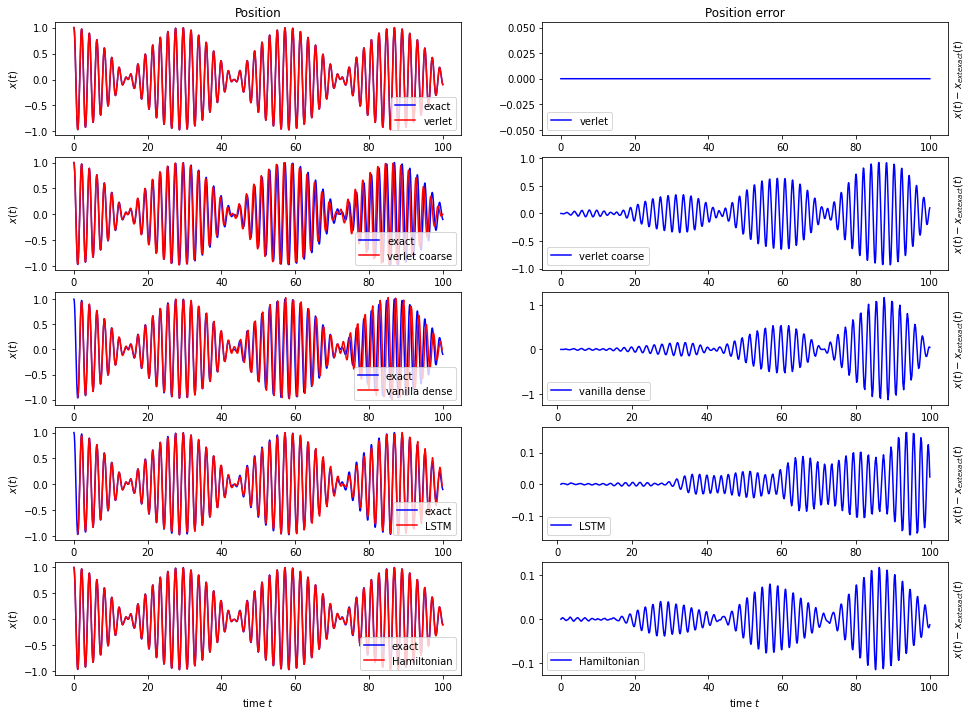

In [22]:

fig, axs = plt.subplots(5,2,figsize=(16, 12))
for j,label in enumerate(('verlet','verlet coarse','vanilla dense','LSTM','Hamiltonian')):
    ax = axs[j][0] 
    ax.plot(t['exact'],q['exact'],label='exact',color='blue')
    ax.plot(t[label],q[label],label=label,color='red')
    ax.legend(loc='lower right')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$x(t)$')
    if j==0:
        ax.set_title('Position')
    ax = axs[j][1] 
    ax.plot(t[label],np.asarray(dq[label]),label=label,color='blue')
    ax.legend(loc='lower left')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$x(t)-x_{\text{exact}}(t)$')
    ax.yaxis.set_label_position("right")
    if j==0:
        ax.set_title('Position error')
plt.show()


# Plot energy drift
Plot the energy drift $E(t)-E(t=0)$ as a function of time $t$ to quantify non-conservation of energy for a numerical integrator.

<Figure size 432x288 with 0 Axes>

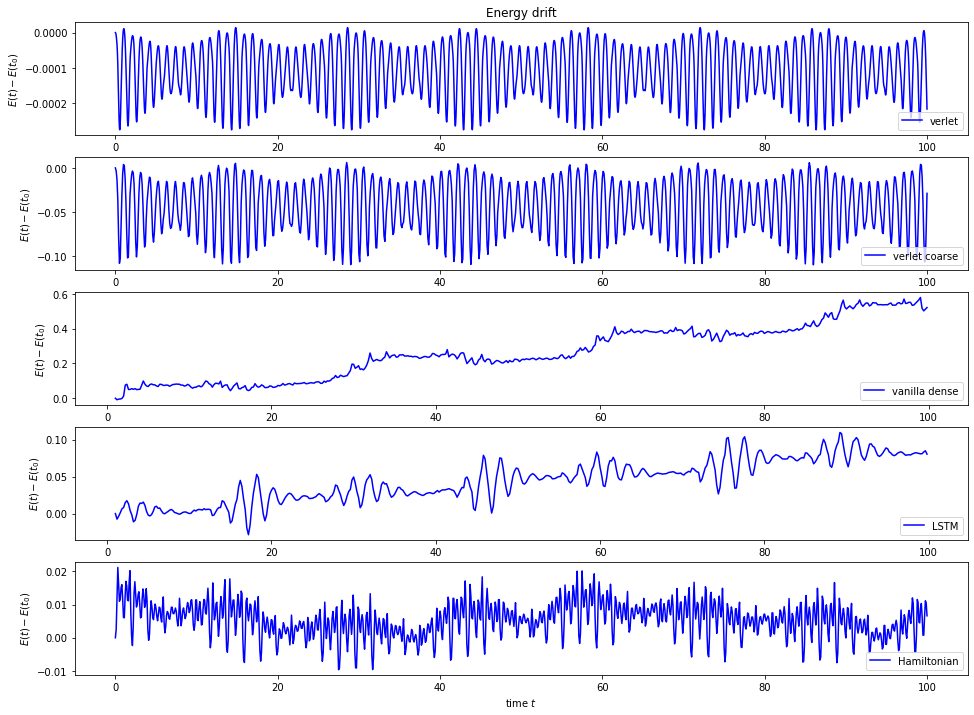

In [17]:
plt.clf()
fig, axs = plt.subplots(5,1,figsize=(16, 12))
for j,label in enumerate(('verlet','verlet coarse','vanilla dense','LSTM','Hamiltonian')):
    ax = axs[j]
    ax.plot(t[label],np.asarray(E[label])-E[label][0],label=label,color='blue')
    ax.legend(loc='lower right')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$E(t)-E(t_0)$')
    if j==0:
        ax.set_title('Energy drift')
plt.show()

## Plot potential and kinetic energy for Harmonic oscillator
For the Harmonic oscillator we know the exact shape of the potential energy $V(x)$ and kinetic energy $T(p)$. Here this is plotted together with the corresponding functions learned by the neural networks. The trained model is loaded from `../assets/trained_models/harmonic_oscillator/hamiltonian_40x`.

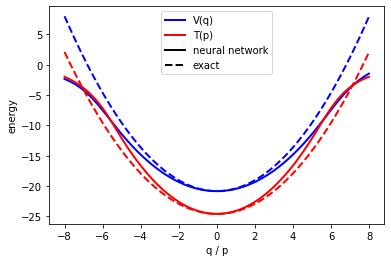

In [21]:
# Plot potential and kinetic energy (for debugging, can only be used with Hamiltonian network)
model = HamiltonianVerletNNIntegrator.load_model('../assets/trained_models/harmonic_oscillator/hamiltonian_40x')
# mass of particle
mass = 1.2
# spring constant
k_spring = 0.9

X = tf.expand_dims(tf.constant(np.arange(-8.0,+8.0,0.01)),axis=1)

# Functions learned by neural network
V_pot = model.layers[-1].V_pot(X).numpy().flatten()
T_kin = model.layers[-1].T_kin(X).numpy().flatten()
# Exact analytical expressions (shifted by minimum of NN expressions)
V_pot_exact = 0.5*k_spring*X**2+np.min(V_pot)
T_kin_exact = 0.5/mass*X**2+np.min(T_kin)
plt.plot(X,V_pot,linewidth=2,color='blue',label='V(q)')
plt.plot(X,T_kin,linewidth=2,color='red',label='T(p)')
plt.plot(X,V_pot_exact,linewidth=2,color='blue',linestyle='--')
plt.plot(X,T_kin_exact,linewidth=2,color='red',linestyle='--')
plt.plot([],[],linewidth=2,color='black',label='neural network')
plt.plot([],[],linewidth=2,color='black',linestyle='--',label='exact')
ax = plt.gca()
ax.set_xlabel('q / p')
ax.set_ylabel('energy')
ax.legend(loc='upper center')
plt.show()